In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

data = pd.read_csv("../input/netflixshows/netflix_titles.csv")

Define the tf-idf vectorizer parameter and convert the description into a tf-idf matrix. Vectorizer uses stopwords to remove words like 'a' or 'the'.

In [12]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(list(data.description))

In [13]:
terms = vectorizer.get_feature_names()

dist is defined as 1 - the cosine equation of each document. Cosine similarity is measured against the tf-idf matrix and can be used to generate a measure of similarity between each document and other documents in the corpus (each description among descriptions). Subtracting it from 1 gives the cosine distance that I will use to plot on a (2-dimensional) euclidean plane.

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(X[:100])

K-means clustering

By using the tf-idf matrix, a grouping algorithm can be performed to better understand the hidden structure in the description.

In [15]:
true_k = 5
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)
clusters = model.labels_.tolist()
order_centroids = model.cluster_centers_.argsort()[:, ::-1]

Create a dataframe consisting of title, type_show, description and cluster. Only limited to 200 data.

In [16]:
netflix = { 'title': list(data.title)[:100], 'type_show': list(data.type)[:100], 'description': list(data.description)[:100], 'cluster': clusters[:100] }
frame = pd.DataFrame(netflix, index = [clusters[:100]] , columns = ['title', 'type_show', 'description', 'cluster'])

Example of data that has been clustered.

In [17]:
from __future__ import print_function

print("Top terms per cluster:")
print()

for i in range(true_k):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :5]:
        print(terms[ind])
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='')
    for title in frame.loc[[i]]['title']:
        print(' %s,' % title, end='')
    print() #add whitespace
    print() #add whitespace


print()
print()

Top terms per cluster:

Cluster 0:
family
man
new
woman
father


Cluster 0 titles: Norm of the North: King Sized Adventure, Jandino: Whatever it Takes, Transformers Prime, Transformers: Robots in Disguise, Automata, Fabrizio Copano: Solo pienso en mi, Good People, Joaquín Reyes: Una y no más, Kidnapping Mr. Heineken, Krish Trish and Baltiboy, Krish Trish and Baltiboy: Battle of Wits, Krish Trish and Baltiboy: Best Friends Forever, Krish Trish and Baltiboy: Comics of India, Krish Trish and Baltiboy: Oversmartness Never Pays, Krish Trish and Baltiboy: The Greatest Trick, Love, Moonwalkers, Rolling Papers, The Runner, City of Joy, First and Last, Next Gen, Sierra Burgess Is A Loser, The Most Assassinated Woman in the World, Article 15, Care of Kancharapalem, Kill Me If You Dare, The Spy, PK, ATM, I Fine... Thank You... Love You, One Day, The World We Make, Black Panther, Man Up, Frequency, Mo Gilligan: Momentum, Adam Ruins Everything, Ben 10, Christiane Amanpour: Sex & Love Around the Wor

**Multidimensional scaling**

Converts the dist matrix into a 2-dimensional array.

In [18]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
xs, ys = pos[:, 0], pos[:, 1]

In [19]:
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#45b6fe'}

cluster_names = {0: 'life,young, new, world, man', 
                 1: 'father, home,murder,family young', 
                 2: 'series,help,world,dcoumentry,new', 
                 3: 'special, stand,comedian,comic,comedy', 
                 4: 'make,face,families,teens,freinds'}

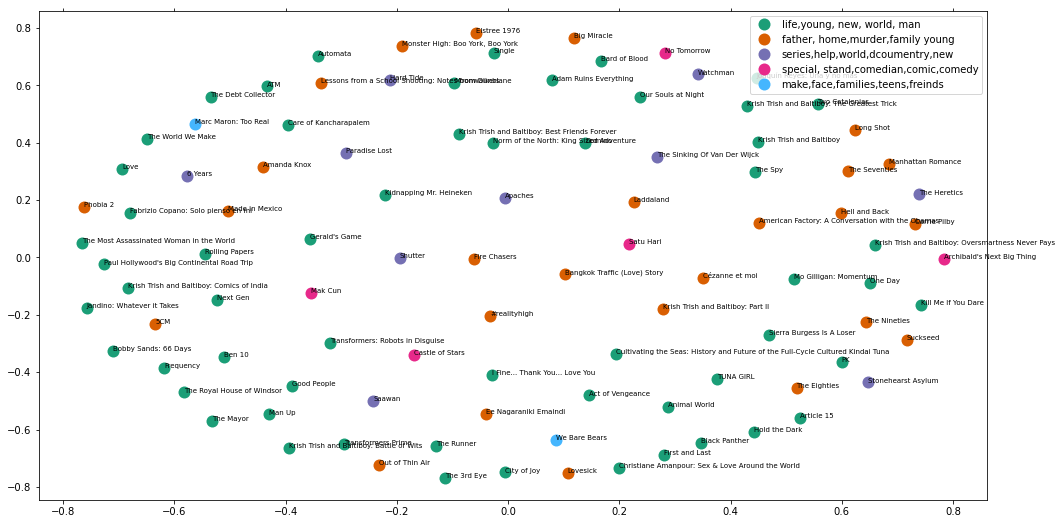

In [20]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters[:100], title=list(data.title)[:100])) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[i]['title'], size=7)  

    
    
plt.show() #show the plot